# Esame 26 febbraio 2024

## Dinatolo Michela e Picciolini Matteo



In questo notebook svolgeremo un'analisi statistica per estrarre informazioni rilevanti dal punto di vista geografico sulla distribuzione dei redditi complessivi e per categoria in Italia.

Questo progetto è suddiviso in:
- Analisi qualitativa del reddito nelle regioni italiane
- Analisi degli andamenti delle categorie di reddito nelle regioni italiane, con focus sul reddito medio da pensione
- Ricerca di correlazioni tra le categorie di reddito

In [1]:
#Importiamo le librerie necessarie
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.stats import trim_mean
from statsmodels import robust
import seaborn as sns
import matplotlib.pylab as plt
import geopandas as gpd
from scipy.stats import norm, skew, kstest, kurtosis
from tabulate import tabulate

In [2]:
#Importiamo i dati e mostriamo le prime 5 righe del dataset
dataframe = pd.read_csv("Redditi_e_principali_variabili_IRPEF_su_base_comunale_CSV_2021.csv", engine='python', sep=";", skipfooter=1, index_col=False)
dataframe = dataframe.drop(dataframe.columns[-1], axis=1)
dataframe.fillna(0, inplace=True)
dataframe.head(5)

,Anno di imposta,Codice catastale,Codice Istat Comune,Denominazione Comune,Sigla Provincia,Regione,Codice Istat Regione,Numero contribuenti,Reddito da fabbricati - Frequenza,Reddito da fabbricati - Ammontare in euro,...,Reddito complessivo da 15000 a 26000 euro - Frequenza,Reddito complessivo da 15000 a 26000 euro - Ammontare in euro,Reddito complessivo da 26000 a 55000 euro - Frequenza,Reddito complessivo da 26000 a 55000 euro - Ammontare in euro,Reddito complessivo da 55000 a 75000 euro - Frequenza,Reddito complessivo da 55000 a 75000 euro - Ammontare in euro,Reddito complessivo da 75000 a 120000 euro - Frequenza,Reddito complessivo da 75000 a 120000 euro - Ammontare in euro,Reddito complessivo oltre 120000 euro - Frequenza,Reddito complessivo oltre 120000 euro - Ammontare in euro
0,2021,A001,28001,ABANO TERME,PD,Veneto,5,15119,7689,9637014,...,4815,98474929,3574.0,125467515.0,505.0,32320379.0,404.0,37960453.0,222.0,48724614.0
1,2021,A004,98001,ABBADIA CERRETO,LO,Lombardia,3,216,91,76792,...,82,1645928,44.0,1408247.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021,A005,97001,ABBADIA LARIANA,LC,Lombardia,3,2499,1204,1845369,...,808,16709574,708.0,24469972.0,80.0,5075985.0,58.0,5344861.0,30.0,5677818.0
3,2021,A006,52001,ABBADIA SAN SALVATORE,SI,Toscana,9,4833,2658,2755446,...,1876,37778285,790.0,26756875.0,66.0,4183252.0,48.0,4453405.0,10.0,1650640.0
4,2021,A007,95001,ABBASANTA,OR,Sardegna,20,1752,880,728377,...,466,9385083,432.0,14545395.0,20.0,1267886.0,20.0,1830232.0,0.0,0.0


### 1. Analisi qualitativa
#### Andamento del rettito in funzione dell'area geografica
Conoscendo i valori del reddito complessivo per varie fasce di reddito per i singoli comuni italiani, abbiamo studiato l'andamento del reddito medio per contribuente nelle regioni italiane. Otteniamo in questo modo un valore del reddito per regione che è indipendente dal numero di contribuenti della regione stessa e ci dà una prima indicazione della ripartizione della ricchezza in Italia. Analizziamo anche l'andamento del reddito medio per provincia.

In [3]:
#Selezioniamo le colonne con il "Reddito complessivo" e sommo sulle singole regioni
classi_di_reddito_columns = dataframe.columns[dataframe.columns.get_loc("Reddito complessivo minore o uguale a zero euro - Frequenza"):50]
classi_di_reddito_per_regione = dataframe.groupby("Codice Istat Regione")[classi_di_reddito_columns].sum()
classi_di_reddito_per_provincia = dataframe.groupby(["Sigla Provincia", "Codice Istat Regione"])[classi_di_reddito_columns].sum()

colonne_reddito = classi_di_reddito_per_regione.columns[classi_di_reddito_per_regione.columns.str.contains('Ammontare in euro')]
colonne_frequenza = classi_di_reddito_per_regione.columns[classi_di_reddito_per_regione.columns.str.contains('Frequenza')]

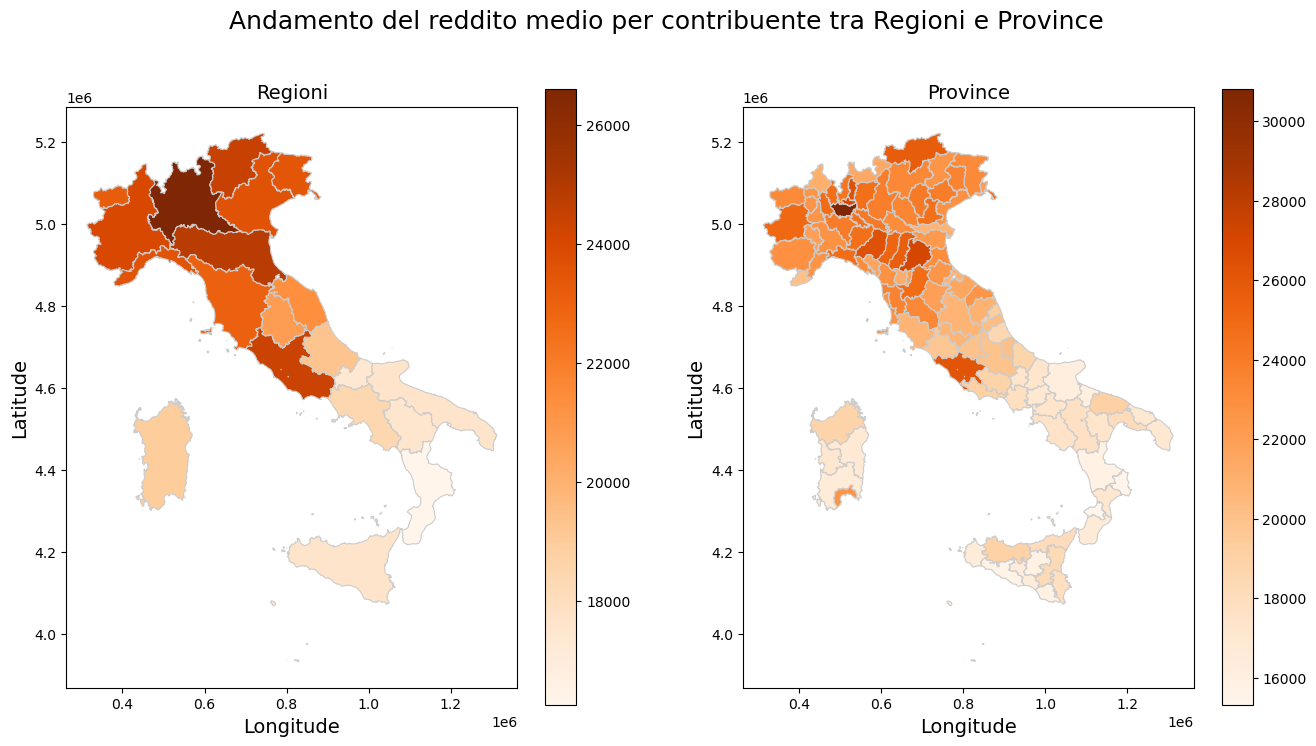

In [4]:
#Utilizziamo una mappa per studiare la distribuzione di ricchezza
#DATI PER REGIONE
summa_reg = classi_di_reddito_per_regione[colonne_reddito[0]]
summa2_reg = classi_di_reddito_per_regione[colonne_frequenza[0]]

for i in range(1, 8): 
    summa_reg += classi_di_reddito_per_regione[colonne_reddito[i]]
    summa2_reg += classi_di_reddito_per_regione[colonne_frequenza[i]]

reddito_medio_per_regione = summa_reg / summa2_reg

reddito_medio_per_regione_dataframe = pd.DataFrame({'Media Pesata per regione': reddito_medio_per_regione})
cartina_regioni = gpd.read_file("Reg01012021_g_WGS84.shp")
cartina_regioni = cartina_regioni.merge(reddito_medio_per_regione_dataframe, left_on='COD_REG', right_on="Codice Istat Regione")

#DATI PER PROVINCIA
summa_prov = classi_di_reddito_per_provincia[colonne_reddito[0]]
summa2_prov = classi_di_reddito_per_provincia[colonne_frequenza[0]]

for i in range(1, 8): 
    summa_prov += classi_di_reddito_per_provincia[colonne_reddito[i]]
    summa2_prov += classi_di_reddito_per_provincia[colonne_frequenza[i]]

reddito_medio_per_prov = summa_prov / summa2_prov

reddito_medio_per_prov_df = pd.DataFrame({'Media Pesata per provincia': reddito_medio_per_prov})

cartina_provincia = gpd.read_file("ProvCM01012021_g_WGS84.shp")
cartina_provincia = cartina_provincia.merge(reddito_medio_per_prov_df, left_on='SIGLA', right_on="Sigla Provincia")

# Primo grafico (Regione)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

cartina_regioni.plot(column='Media Pesata per regione', cmap='Oranges', linewidth=0.8, ax=axes[0], edgecolor='0.8', legend=True)
axes[0].set_title('Regioni', fontsize = 14)
axes[0].set_xlabel('Longitude', fontsize = 14)
axes[0].set_ylabel('Latitude', fontsize = 14)

# Secondo grafico (Provincia)
cartina_provincia.plot(column='Media Pesata per provincia', cmap='Oranges', linewidth=0.8, ax=axes[1], edgecolor='0.8', legend=True)
axes[1].set_title('Province', fontsize = 14)
axes[1].set_xlabel('Longitude', fontsize = 14)
axes[1].set_ylabel('Latitude', fontsize = 14)

plt.suptitle('Andamento del reddito medio per contribuente tra Regioni e Province', fontsize=18)

plt.show()

#TASSE??


Notiamo dunque che in generale le regioni del Nord e Centro Italia hanno un reddito medio per contribuente superiore a quello delle regioni del Sud e delle Isole. Osserviamo meglio questo andamento con un boxplot.

In [5]:
reddito_medio_per_prov_df = reddito_medio_per_prov_df.reset_index()
reddito_medio_per_prov_df.columns = ['Sigla Provincia', 'Codice Istat Regione', 'Media Pesata per provincia']
reddito_medio_per_prov_df.head(5)

,Sigla Provincia,Codice Istat Regione,Media Pesata per provincia
0,0,15,19376.077424
1,AG,19,15550.217948
2,AL,1,22754.227390
3,AN,11,22651.181148
4,AO,2,23184.073854


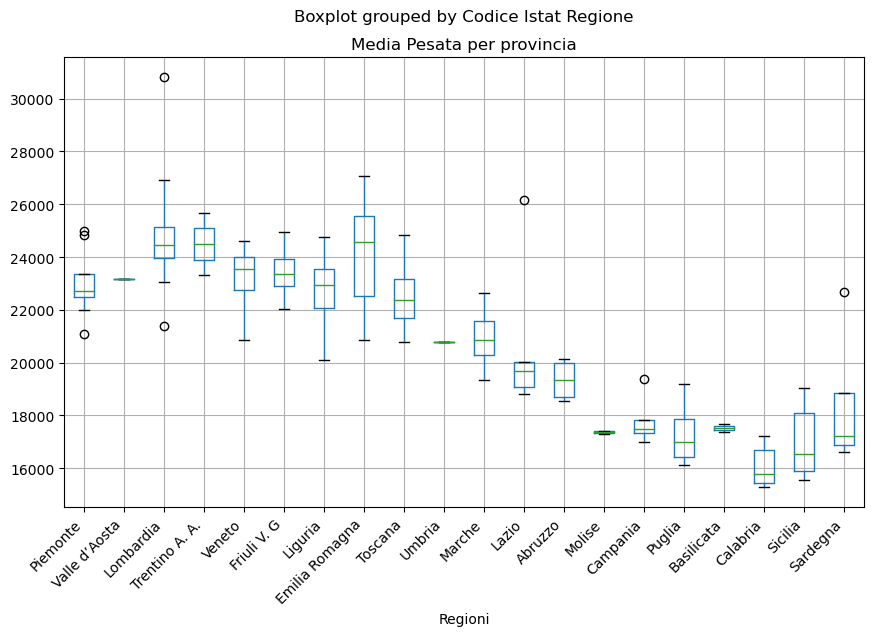

In [6]:
boxplot = reddito_medio_per_prov_df.boxplot(column='Media Pesata per provincia', by='Codice Istat Regione', figsize=(10, 6))
regioni = ['Piemonte', 'Valle d’Aosta', 'Lombardia', 'Trentino A. A.', 'Veneto', 'Friuli V. G', 'Liguria', 'Emilia Romagna', 'Toscana', 'Umbria', 'Marche', 'Lazio', 'Abruzzo', 'Molise', 'Campania', 'Puglia', 'Basilicata', 'Calabria', 'Sicilia', 'Sardegna']
boxplot.set_xticklabels(regioni, rotation=45, ha='right')
boxplot.set_xlabel('Regioni')
plt.show()

Si osserva dunque che in generale **l'andamento del reddito medio per provincia nelle regioni italiane decresce man mano che ci si sposta dal Nord verso il Sud**. Dividiamo quindi le regioni in quattro macro-aree:

- **Nord**: Piemonte, Valle d'Aosta, Lombardia, Trentino Alto Adige, Veneto, Friuli Venezia Giulia, Liguria, Emilia Romagna
- **Centro**: Toscana, Umbria, Marche, Lazio
- **Sud**: Abruzzo, Molise, Campania, Puglia, Basilicata, Calabria
- **Isole**: Sicilia, Sardegna

Andiamo ad osservare con uno scatterplot l'andamento delle frequenze osservate per ciascuna classe di reddito nelle province italiane. In particolare ci chiediamo se le regioni del Nord e Centro Italia presentino un reddito complessivo maggiore perchè hanno un numero più alto di contribuenti o se invece i singoli contribuenti presentino un reddito maggiore.

In [7]:
sum_df = pd.DataFrame({'Frequenze': summa2_prov, 'Reddito Totale': summa_prov})
sum_df = sum_df.reset_index()
sum_df.columns = ['Sigla Provincia', 'Codice Istat Regione', 'Frequenze', 'Reddito Totale']

In [8]:
def assign_class(x):
    if x <= 8:
        return 1
    elif (x >= 9 and x <= 12):
        return 2
    elif (x >= 13 and x <= 18):
        return 3
    else:
        return 4
sum_df['Classe'] = sum_df['Codice Istat Regione'].apply(assign_class)

Legge di potenza per le regioni del Nord: Contribuenti = 0.00062 * Reddito_totale^(0.88)
Legge di potenza per le regioni del Centro: Contribuenti = 0.00025 * Reddito_totale^(0.92)
Legge di potenza per le regioni del Sud: Contribuenti = 0.00023 * Reddito_totale^(0.94)
Legge di potenza per le Isole: Contribuenti = 0.00028 * Reddito_totale^(0.93)


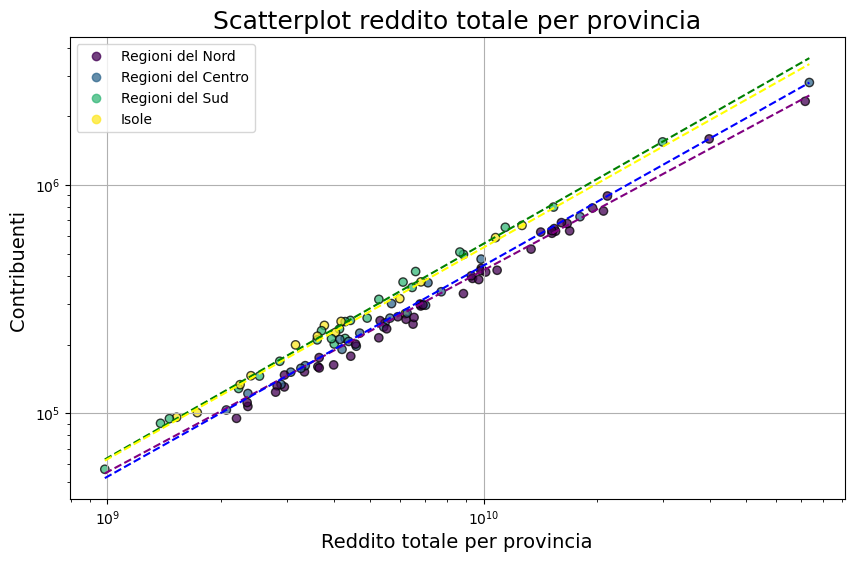

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Funzione per la regressione con legge di potenza
def power_law_regression(x, a, b):
    return a * np.power(x, b)

# Separare i dati per classe
nord = sum_df[sum_df['Classe'] == 1]
centro = sum_df[sum_df['Classe'] == 2]
sud = sum_df[sum_df['Classe'] == 3]
isole = sum_df[sum_df['Classe'] == 4]

# Fai il fit per ogni classe con legge di potenza
popt_1, pcov_1 = curve_fit(power_law_regression, nord['Reddito Totale'], nord['Frequenze'])
popt_2, pcov_2 = curve_fit(power_law_regression, centro['Reddito Totale'], centro['Frequenze'])
popt_3, pcov_3 = curve_fit(power_law_regression, sud['Reddito Totale'], sud['Frequenze'])
popt_4, pcov_4 = curve_fit(power_law_regression, isole['Reddito Totale'], isole['Frequenze'])

# Plot dei dati e delle curve di fit
plt.figure(figsize=(10,6))
scatter = plt.scatter(sum_df['Reddito Totale'], sum_df['Frequenze'], c=sum_df['Classe'], edgecolors='k', alpha=0.75, label=['Regioni del Nord', 'Regioni del Centro', 'Regioni del Sud', 'Isole'])
plt.grid(True)
plt.title("Scatterplot reddito totale per provincia", fontsize=18)
plt.xlabel("Reddito totale per provincia", fontsize=14)
plt.ylabel("Contribuenti ", fontsize=14)

# Crea la legenda associando etichette alle classi
plt.legend(handles=scatter.legend_elements()[0], labels=['Regioni del Nord', 'Regioni del Centro', 'Regioni del Sud', 'Isole'])

# Plot delle curve di fit e inserimento dei parametri nel label
x_range = np.linspace(min(sum_df['Reddito Totale']), max(sum_df['Reddito Totale']), 100)
plt.plot(x_range, power_law_regression(x_range, popt_1[0], popt_1[1]), '--', color='purple')
plt.plot(x_range, power_law_regression(x_range, popt_2[0], popt_2[1]), '--', color='blue')
plt.plot(x_range, power_law_regression(x_range, popt_3[0], popt_3[1]), '--', color='green')
plt.plot(x_range, power_law_regression(x_range, popt_4[0], popt_4[1]), '--', color='yellow')

plt.xscale('log')
plt.yscale('log')

print("Legge di potenza per le regioni del Nord: Contribuenti = {:.5f} * Reddito_totale^({:.2f})".format(popt_1[0], popt_1[1]))
print("Legge di potenza per le regioni del Centro: Contribuenti = {:.5f} * Reddito_totale^({:.2f})".format(popt_2[0], popt_2[1]))
print("Legge di potenza per le regioni del Sud: Contribuenti = {:.5f} * Reddito_totale^({:.2f})".format(popt_3[0], popt_3[1]))
print("Legge di potenza per le Isole: Contribuenti = {:.5f} * Reddito_totale^({:.2f})".format(popt_4[0], popt_4[1]))

plt.show()


Si nota quindi che, a parità di reddito complessivo della provincia, le regioni del Sud Italia e le Isole presentano una frequenza maggiore di contribuenti. Dunque deduciamo che un reddito alto nelle regioni del Centro-Nord corrisponde a un reddito medio maggiore piuttosto che a un numero di contribuenti maggiore nella provincia di interesse. In particolare con questo grafico evidenziamo il fatto che l'andamento del numero di contribuenti in funzione del reddito totale per provincia segue una legge di potenza con esponente circa pari a $1$.

#### Fasce di reddito
Ci chiediamo ora come si distribuisca il reddito nelle varie fasce. Ci aspettiamo di trovare pochi contribuenti con un valore di reddito nelle fasce alte e invece frequenze maggiori nelle classi intermedie.

In [10]:
reddito = dataframe[colonne_reddito].sum()
frequenza = dataframe[colonne_frequenza].sum()

somma = pd.DataFrame({'somma reddito': reddito, 'somma frequenza': frequenza})
somma.index = somma.index.str.replace(' - Ammontare in euro', '').str.replace(' - Frequenza', '')

df_collapsed = somma.groupby(somma.index).sum()
df_collapsed = df_collapsed.dropna(how='all')
df_collapsed = df_collapsed.drop(df_collapsed.index[-2])
df_collapsed

,somma reddito,somma frequenza
Reddito complessivo da 0 a 10000 euro,5.188857e+10,11360246.0
Reddito complessivo da 10000 a 15000 euro,6.600743e+10,5289062.0
Reddito complessivo da 15000 a 26000 euro,2.479681e+11,12131672.0
Reddito complessivo da 26000 a 55000 euro,3.328410e+11,9610390.0
Reddito complessivo da 55000 a 75000 euro,6.104667e+10,959525.0
Reddito complessivo da 75000 a 120000 euro,6.820885e+10,741524.0
Reddito complessivo oltre 120000 euro,8.339816e+10,371831.0


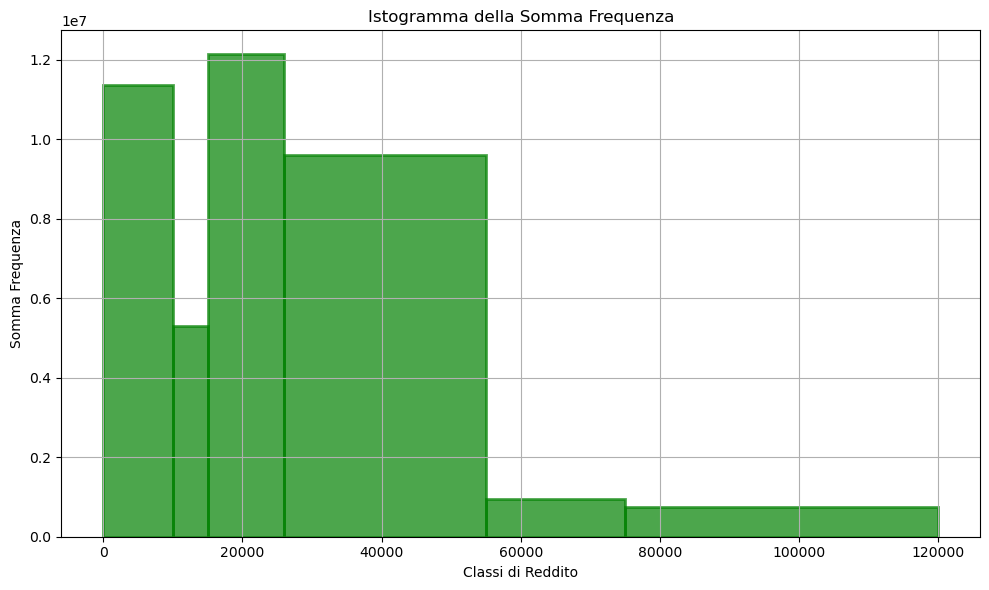

In [11]:
data = {
    'somma reddito': [0, 10000, 15000, 26000, 55000, 75000, 120000, float('inf')],
    'somma frequenza': df_collapsed['somma frequenza'].values
}

# Calcolo delle larghezze degli intervalli
bin_edges = data['somma reddito']
bin_widths = [bin_edges[i+1] - bin_edges[i] for i in range(len(bin_edges)-1)]

# Plot dell'istogramma
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], data['somma frequenza'], width=bin_widths, align='edge', color='green', alpha=0.7, linewidth=2,edgecolor='green')
plt.xlabel('Classi di Reddito')
plt.ylabel('Somma Frequenza')
plt.title('Istogramma della Somma Frequenza')
plt.grid(True)
plt.tight_layout()
plt.show()

Questo istogramma conferma quanto previsto: il numero di contribuenti nelle fasce di reddito alto è molto inferioriore rispetto a quelle di reddito medio-basso. Purtroppo, in mancanza di informazioni aggiuntive, non è stato possibile stabilire con certezza la distribuzione associata a questo istogramma, poiché i range tra le varie classi fornite dal database sono pochi e troppo diversificati tra loro, come è ben visibile dall'istogramma.

In ogni caso, è comunque possibile discutere la distribuzione dei redditi e della popolazione nelle varie classi attraverso il seguente grafico:

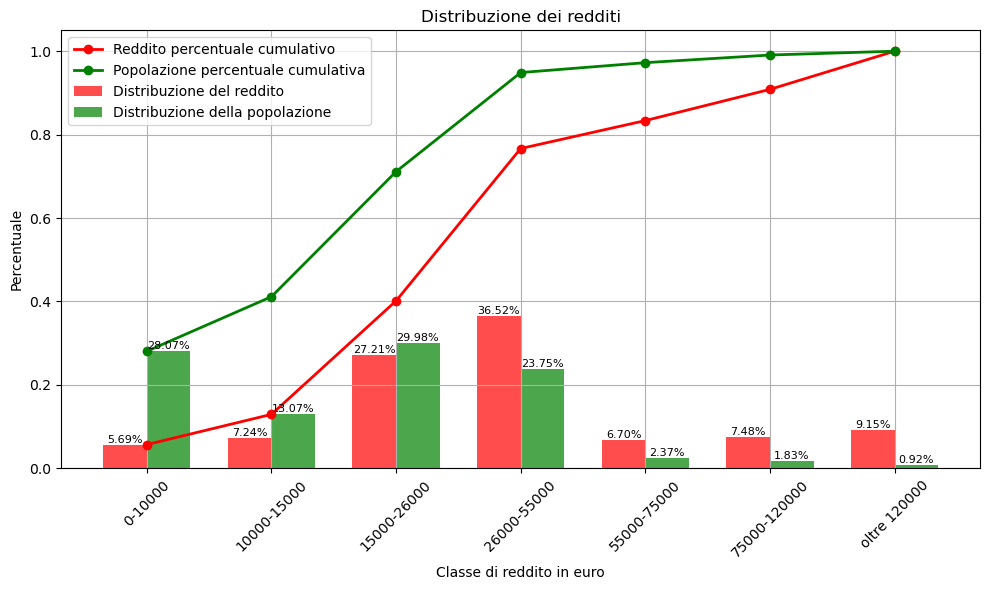

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
# Creiamo un DataFrame con i dati forniti
data = {
    'Classe di reddito': [
        '0-10000', '10000-15000', '15000-26000', '26000-55000',
        '55000-75000', '75000-120000', 'oltre 120000'
    ],
    'Somma Reddito (Euro)': [
        5.188857e+10, 6.600743e+10, 2.479681e+11, 3.328410e+11,
        6.104667e+10, 6.820885e+10, 8.339816e+10
    ],
    'Numero di Contribuenti': [
        11360246.0, 5289062.0, 12131672.0, 9610390.0,
        959525.0, 741524.0, 371831.0
    ]
}

df = pd.DataFrame(data)

# Calcoliamo la percentuale del reddito complessivo per ogni classe di reddito
df['Percentuale Reddito'] = df['Somma Reddito (Euro)'] / df['Somma Reddito (Euro)'].sum()

# Calcoliamo la percentuale della popolazione per ogni classe di reddito
df['Percentuale Popolazione'] = df['Numero di Contribuenti'] / df['Numero di Contribuenti'].sum()

# Calcoliamo la ricchezza cumulativa e la popolazione cumulativa
df['Ricchezza Cumulativa'] = df['Percentuale Reddito'].cumsum()
df['Popolazione Cumulativa'] = df['Percentuale Popolazione'].cumsum()

# Plottiamo l'istogramma
# Calcoliamo la larghezza delle barre
bar_width = 0.35

# Calcoliamo il centro di ogni gruppo di barre
index = np.arange(len(df['Classe di reddito']))

# Ordina il DataFrame in base alla classe di reddito
df = df.sort_values(by='Classe di reddito')

# Plottiamo l'istogramma
plt.figure(figsize=(10, 6))
bars1 = plt.bar(index - bar_width/2, df['Percentuale Reddito'], bar_width, color='red', alpha=0.7, label='Distribuzione del reddito')
bars2 = plt.bar(index + bar_width/2, df['Percentuale Popolazione'], bar_width, color='green', alpha=0.7, label='Distribuzione della popolazione')

plt.plot(index, df['Ricchezza Cumulativa'], color='red', marker='o', linestyle='-', linewidth=2, label='Reddito percentuale cumulativo')
plt.plot(index, df['Popolazione Cumulativa'], color='green', marker='o', linestyle='-', linewidth=2, label='Popolazione percentuale cumulativa')

plt.xlabel('Classe di reddito in euro')
plt.ylabel('Percentuale')
plt.title('Distribuzione dei redditi')
plt.legend()
plt.xticks(index, df['Classe di reddito'], rotation=45)
plt.grid(True)

# Aggiungiamo i valori percentuali sopra ogni barra
for bar1, bar2 in zip(bars1, bars2):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    plt.text(bar1.get_x() + bar1.get_width()/2., height1, '{:.2%}'.format(height1), ha='center', va='bottom', color='black', fontsize=8)
    plt.text(bar2.get_x() + bar2.get_width()/2., height2, '{:.2%}'.format(height2), ha='center', va='bottom', color='black', fontsize=8)

plt.tight_layout()
plt.show()

Questo grafico mostra il numero di contribuenti e il reddito totale in percentuale per ogni classe di reddito. Si nota immediatamente che la maggior parte del contributo al reddito totale sia dato dalla terza e quarta fascia di reddito. La prima fascia di reddito mostra, invece, un elevato numero di contribuenti rispetto alle altre classi ma che partecipano al reddito complessivo per solo il $6\%$. Al contrario, le ultime tre classi assieme sono costituite dal $5\%$ dei contribuenti totali, che però percepiscono un reddito pari a più del $23\%$ del reddito complessivo italiano. 

Questa disuguaglianza tra classi è stimabile attraverso l'[indice di Gini](https://en.wikipedia.org/wiki/Gini_coefficient). Valori bassi del coefficiente indicano una distribuzione abbastanza omogenea, con il valore $0$ che corrisponde alla pura equidistribuzione, ad esempio la situazione in cui tutti percepiscono esattamente lo stesso reddito; valori alti del coefficiente indicano una distribuzione più diseguale, con il valore $1$ che corrisponde alla massima concentrazione, ovvero la situazione dove una persona percepisca tutto il reddito del paese mentre tutti gli altri hanno un reddito nullo. 


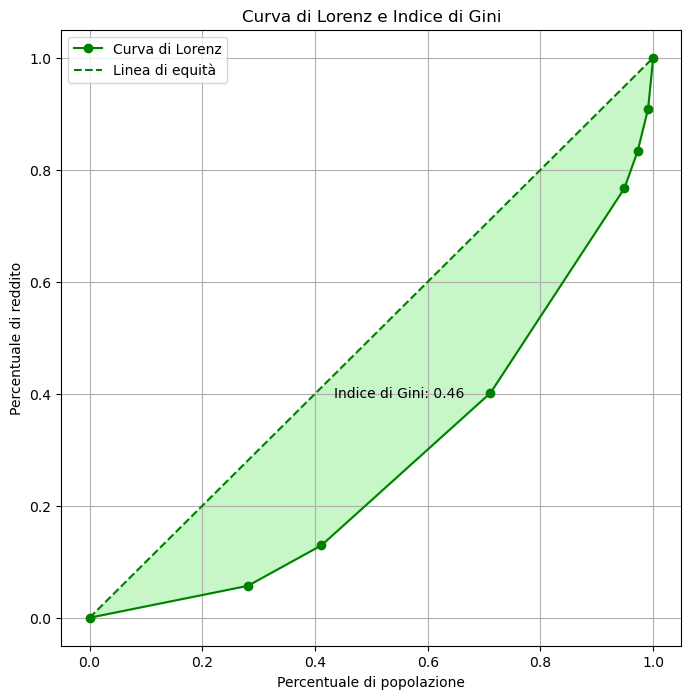

In [13]:
df.loc[-1] = [0, 0, 0, 0, 0, 0, 0]
df.index = df.index + 1
df = df.sort_index()

# Calcoliamo l'area sottesa alla curva di Lorenz (A_Lorenz) e l'area del triangolo perfetto (A_Triangle)
A_Lorenz = simps(df['Ricchezza Cumulativa'], df['Popolazione Cumulativa'])
A_Triangle = 0.5

# Calcoliamo l'indice di Gini come A_Triangle / (A_Triangle + A_Lorenz)
Gini_Index = 1-2*A_Lorenz

# Plottiamo la curva di Lorenz e il triangolo perfetto
plt.figure(figsize=(8, 8))
plt.plot(df['Popolazione Cumulativa'], df['Ricchezza Cumulativa'], label='Curva di Lorenz', color='green', marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', label='Linea di equità', color='green')
plt.fill_between(df['Popolazione Cumulativa'], df['Ricchezza Cumulativa'], df['Popolazione Cumulativa'], color='lightgreen', alpha=0.5)
plt.text(0.55, 0.4, 'Indice di Gini: {:.2f}'.format(Gini_Index), color= "black", horizontalalignment='center', verticalalignment='center')
plt.xlabel('Percentuale di popolazione')
plt.ylabel('Percentuale di reddito')
plt.title('Curva di Lorenz e Indice di Gini')
plt.legend()
plt.grid(True)
plt.show()


In questo grafico si mostra la percentuale di reddito in funzione della percentuale di popolazione. L'indice di Gini è dato dall'estensione dell'area colorata in verde, ovvero dall'area sottesa da una curva di ipotetica equidistribuzione a cui va sottratta l'area sottesa dalla curva effettivamente trovata coi dati. 
L'indice trovato, di circa $0.46$, è in linea con quello calcolato ufficialmente da Istat.

### 2. Analisi delle categorie di reddito

Ci chiediamo a questo punto da che categoria provenga il contributo maggiore al reddito complessivo per le regioni italiane. Consideriamo quindi l'andamento del reddito medio per regione per categoria.

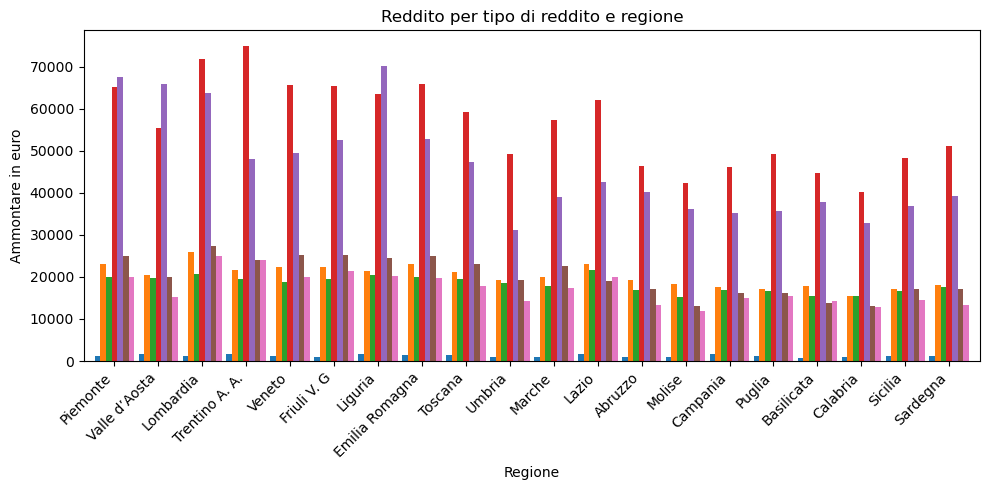

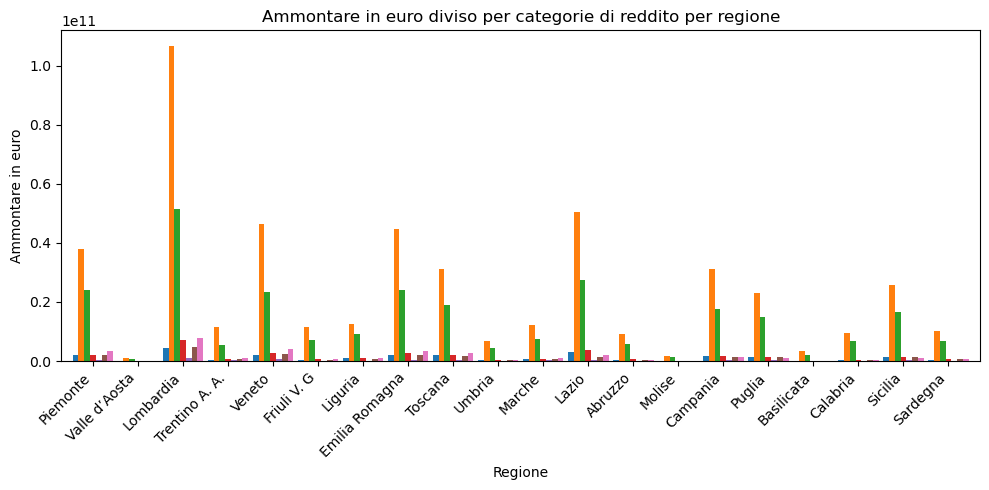

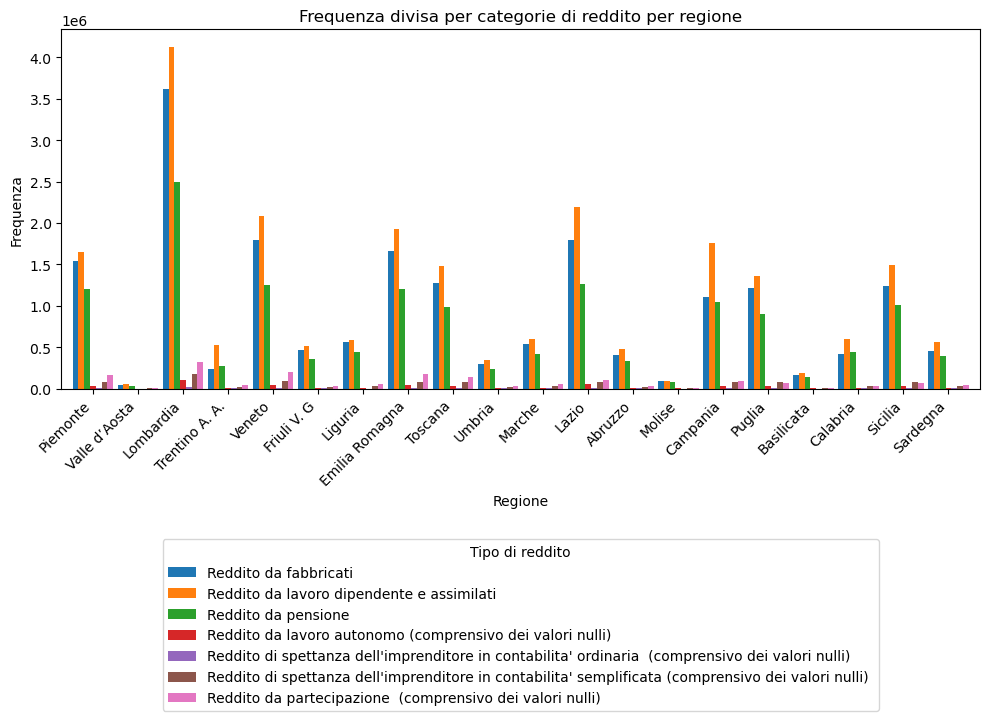

In [33]:
redditi_columns = dataframe.columns[dataframe.columns.get_loc("Reddito da fabbricati - Frequenza"):dataframe.columns.get_loc("Reddito imponibile - Frequenza")]
redditi_per_regione = dataframe.groupby("Codice Istat Regione")[redditi_columns].sum()

colonne_reddito_cat = redditi_per_regione.columns[redditi_per_regione.columns.str.contains('Ammontare in euro')]
colonne_frequenza_cat = redditi_per_regione.columns[redditi_per_regione.columns.str.contains('Frequenza')]


# Supponendo che il DataFrame si chiami "dataframe"



media = redditi_per_regione[colonne_reddito_cat].div(redditi_per_regione[colonne_frequenza_cat].values)
media.plot(kind='bar', figsize=(10, 5), width=0.9, legend=False)
plt.title('Reddito per tipo di reddito e regione')
plt.xlabel('Regione')
plt.ylabel('Ammontare in euro')
plt.xticks(range(len(regioni)),regioni, rotation=45,ha='right')


plt.tight_layout()
plt.show()


categorie_ammontare_in_euro = redditi_per_regione[colonne_reddito_cat]

categorie_ammontare_in_euro.plot(kind='bar', figsize=(10, 5), width=0.9, legend= False)
plt.title('Ammontare in euro diviso per categorie di reddito per regione')
plt.xlabel('Regione')
plt.ylabel('Ammontare in euro')
plt.xticks(range(len(regioni)),regioni, rotation=45,ha='right')


plt.tight_layout()
plt.show()


categorie_ammontare_in_euro = redditi_per_regione[colonne_frequenza_cat]
categorie_ammontare_in_euro.columns = categorie_ammontare_in_euro.columns.str.replace('- Frequenza', '')
categorie_ammontare_in_euro.plot(kind='bar', figsize=(10, 8.5), width=0.9)
plt.title('Frequenza divisa per categorie di reddito per regione')
plt.xlabel('Regione')
plt.ylabel('Frequenza')
plt.xticks(range(len(regioni)),regioni, rotation=45, ha='right')

# Rimuovere completamente la legenda
plt.legend(title='Tipo di reddito', loc='upper center', bbox_to_anchor=(0.5, -0.4))

plt.tight_layout()
plt.show()



Dal secondo e terzo istogramma notiamo che chi fornisce il contributo maggiore al reddito complessivo non è la categoria di contribuenti che ha reddito medio maggiore, quella con un numero di contribuenti maggiore. Ad esempio, il contributo maggiore al reddito totale regionale è dato dalla categoria *Reddito da lavoro dipendente e assimilati*.

In particolare dal secondo istogramma si nota che il contributo maggiore al reddito è dato da due categorie: *Reddito da lavoro dipendente e assimilati* e *Reddito da pensione*. 

Scegliamo di concentrarci sul reddito da pensione e analizziamo il suo andamento nelle regioni italiane per capire in che modo si distribuisca. Ci aspettiamo di ottenere un andamento gaussiano.

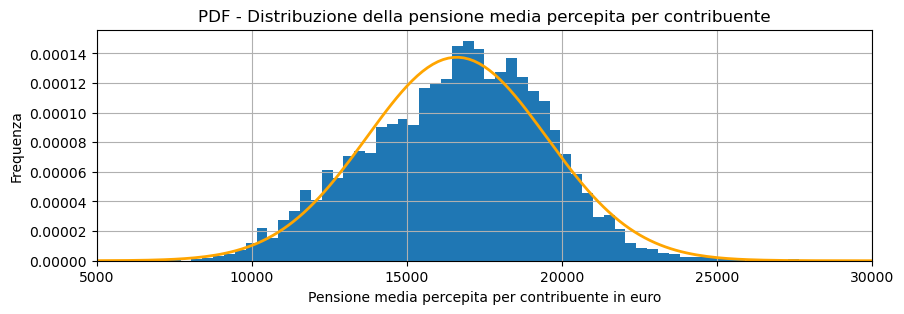

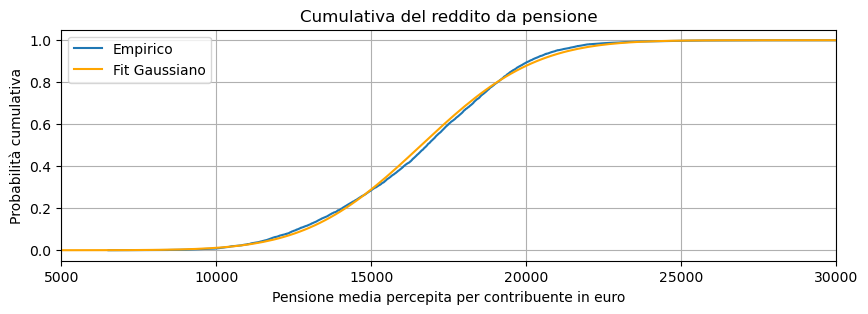

Risultati del test di Kolmogorov-Smirnov: 
Statistiche KS: 0.029947890339179717
p-value: 1.3613009229059714e-06


In [15]:
# Dati
data = dataframe['Reddito da pensione - Ammontare in euro'].div(dataframe['Reddito da pensione - Frequenza'].values)

# Bins
binwidth = 350
bins = np.arange(0, 50000 + binwidth, binwidth)

#Fit
mu, std = norm.fit(data)

# Plot
plt.figure(figsize=(10, 3))
data.hist(bins=bins, density = True)

# Plot PDF
x = np.linspace(0, 1e6, 6000)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'orange', linewidth=2)

# Style
plt.xlim(5000, 30000)
plt.ylabel("Frequenza")
plt.xlabel("Pensione media percepita per contribuente in euro")
plt.title("PDF - Distribuzione della pensione media percepita per contribuente")

################################################################################################

# Dati
data_sorted = np.sort(data)
cdf_data = np.arange(len(data_sorted)) / float(len(data_sorted))

# Fit
mean_data, std_data = norm.fit(data)
cdf_norm_data = norm.cdf(x, mean_data, std_data)


plt.figure(figsize=(10, 3))

# Plot della CDF empirica e del fit gaussiano
plt.plot(data_sorted, cdf_data, label='Empirico')
plt.plot(x, cdf_norm_data, label='Fit Gaussiano', color='orange')


# Style
plt.xlabel("Pensione media percepita per contribuente in euro")
plt.ylabel("Probabilità cumulativa")
plt.title("Cumulativa del reddito da pensione")
plt.legend()
plt.xlim(5000, 30000)
plt.grid()
plt.show()


# Kolmogorov-Smirnov 
ks_statistic_data, ks_pvalue_data = kstest(data_sorted, 'norm', args=(mean_data, std_data))
print("Risultati del test di Kolmogorov-Smirnov: ")
print("Statistiche KS:", ks_statistic_data)
print("p-value:", ks_pvalue_data)

Abbiamo utilizzato un test di Kolmogorov-Smirnov per verificare l'ipotesi nulla di andamento gaussiano per la distribuzione del reddito medio da pensione nelle province italiane. Per i valori ottenuti per il test l'ipotesi è da rigettare. Ipotizziamo a questo punto che tale risultato sia dovuto al fatto che la distribuzione del reddito medio italiano è la somma di distribuzioni differenti per le varie regioni. Utilizziamo, allora, le 4 macro-aree di cui sopra e analizziamo i dati mediante lo stesso test.

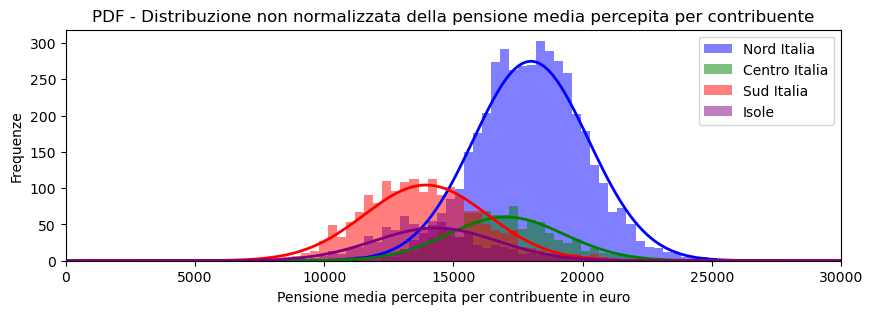

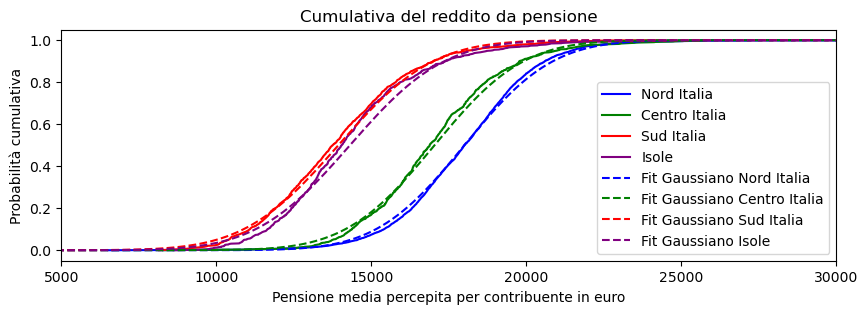

Test di Kolmogorov-Smirnov per Nord Italia:
Statistiche KS: 0.02744288344203949
P-value: 0.0026565848299833785

Test di Kolmogorov-Smirnov per Centro Italia:
Statistiche KS: 0.0499488875714027
P-value: 0.015423619792689372

Test di Kolmogorov-Smirnov per Sud Italia:
Statistiche KS: 0.0367633577026415
P-value: 0.015735662311776005

Test di Kolmogorov-Smirnov per Isole:
Statistiche KS: 0.07147635663156571
P-value: 0.0007403009866925396


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
dataframe['Classe'] = dataframe['Codice Istat Regione'].apply(assign_class)
# Co
colors = ['blue', 'green', 'red', 'purple']
nome_classe = ['Nord Italia', 'Centro Italia', 'Sud Italia', 'Isole']

# Figure
plt.figure(figsize=(10, 3))

fitted_curves = []
for classe in range(1, 5):
    # Dati
    data = dataframe.loc[dataframe['Classe'] == classe]['Reddito da pensione - Ammontare in euro'].div(dataframe.loc[dataframe['Classe'] == classe]['Reddito da pensione - Frequenza'].values)
    
    # Calcola i parametri della distribuzione normale per la classe attuale
    mu, std = norm.fit(data)
    
    # Plot dell'istogramma
    plt.hist(data, bins=bins, alpha=0.5, color=colors[classe-1], label=nome_classe[classe-1])
    
    # Plot della PDF della distribuzione normale senza normalizzazione
    p = norm.pdf(x, mu, std) * len(data) * binwidth  # Multiplico per il numero di dati e la larghezza del bin per ottenere il valore non normalizzato
    plt.plot(x, p, color=colors[classe-1], linewidth=2)
    
    # Aggiungi la curva fittata alla lista
    fitted_curves.append(p)
    
plt.legend()

# Imposta il limite sull'asse x
plt.xlim(0, 30000)

# Aggiungi titolo e label agli assi
plt.title('PDF - Distribuzione non normalizzata della pensione media percepita per contribuente')
plt.xlabel('Pensione media percepita per contribuente in euro')
plt.ylabel('Frequenze')

# Visualizza il grafico
plt.show()


######################################################################################

Nord_Italy = dataframe.loc[dataframe['Classe'] == 1]['Reddito da pensione - Ammontare in euro'].div(dataframe.loc[dataframe['Classe'] == 1]['Reddito da pensione - Frequenza'].values)
Center_Italy = dataframe.loc[dataframe['Classe'] == 2]['Reddito da pensione - Ammontare in euro'].div(dataframe.loc[dataframe['Classe'] == 2]['Reddito da pensione - Frequenza'].values)
Sud_Italy = dataframe.loc[dataframe['Classe'] == 3]['Reddito da pensione - Ammontare in euro'].div(dataframe.loc[dataframe['Classe'] == 3]['Reddito da pensione - Frequenza'].values)
Isle_Italy = dataframe.loc[dataframe['Classe'] == 4]['Reddito da pensione - Ammontare in euro'].div(dataframe.loc[dataframe['Classe'] == 4]['Reddito da pensione - Frequenza'].values)

mean_N = np.mean(Nord_Italy)
std_N = np.std(Nord_Italy)

mean_C = np.mean(Center_Italy)
std_C = np.std(Center_Italy)

mean_S = np.mean(Sud_Italy)
std_S = np.std(Sud_Italy)

mean_I = np.mean(Isle_Italy)
std_I = np.std(Isle_Italy)

nord_sorted = np.sort(Nord_Italy)
sud_sorted = np.sort(Sud_Italy)
center_sorted = np.sort(Center_Italy)
isle_sorted = np.sort(Isle_Italy)

cdf_nord = np.arange(len(nord_sorted)) / float(len(nord_sorted))
cdf_center = np.arange(len(center_sorted)) / float(len(center_sorted))
cdf_sud = np.arange(len(sud_sorted)) / float(len(sud_sorted))
cdf_isle = np.arange(len(isle_sorted)) / float(len(isle_sorted))

plt.figure(figsize=(10,3))
plt.plot(nord_sorted, cdf_nord, label='Nord Italia', color='blue')
plt.plot(center_sorted, cdf_center, label='Centro Italia', color='green')
plt.plot(sud_sorted, cdf_sud, label='Sud Italia', color='red')
plt.plot(isle_sorted, cdf_isle, label='Isole', color='purple')


cdf_norm_nord = norm.cdf(x, mean_N, std_N)
cdf_norm_center = norm.cdf(x, mean_C, std_C)
cdf_norm_sud = norm.cdf(x, mean_S, std_S)
cdf_norm_isle = norm.cdf(x, mean_I, std_I)

plt.plot(x, cdf_norm_nord, label='Fit Gaussiano Nord Italia', color='blue', linestyle='--')
plt.plot(x, cdf_norm_center, label='Fit Gaussiano Centro Italia', color='green', linestyle='--')
plt.plot(x, cdf_norm_sud, label='Fit Gaussiano Sud Italia', color='red', linestyle='--')
plt.plot(x, cdf_norm_isle, label='Fit Gaussiano Isole', color='purple', linestyle='--')

plt.xlabel("Pensione media percepita per contribuente in euro")
plt.ylabel("Probabilità cumulativa")
plt.title("Cumulativa del reddito da pensione")
plt.legend()
plt.xlim(5000, 30000)
plt.show()

# Test di Kolmogorov-Smirnov
ks_statistic_nord, p_value_nord = kstest(Nord_Italy, 'norm', args=(mean_N, std_N))
ks_statistic_center, p_value_center = kstest(Center_Italy, 'norm', args=(mean_C, std_C))
ks_statistic_sud, p_value_sud = kstest(Sud_Italy, 'norm', args=(mean_S, std_S))
ks_statistic_isle, p_value_isle = kstest(Isle_Italy, 'norm', args=(mean_I, std_I))

print("Test di Kolmogorov-Smirnov per Nord Italia:")
print("Statistiche KS:", ks_statistic_nord)
print("P-value:", p_value_nord)

print("\nTest di Kolmogorov-Smirnov per Centro Italia:")
print("Statistiche KS:", ks_statistic_center)
print("P-value:", p_value_center)

print("\nTest di Kolmogorov-Smirnov per Sud Italia:")
print("Statistiche KS:", ks_statistic_sud)
print("P-value:", p_value_sud)

print("\nTest di Kolmogorov-Smirnov per Isole:")
print("Statistiche KS:", ks_statistic_isle)
print("P-value:", p_value_isle)


Come possiamo osservare dai *p-value* ottenuti, l'ipotesi non è da rigettare solamente nel caso delle regioni del Centro-Sud, per le quali si ha un **p-value* $> 0.01$**.

Ci chiediamo dunque perché per il Nord e per le Isole non si osservi tale andamento. Calcoliamo quindi i **p-value** per le singole regioni, prendendo come ipotesi nulla un andamento gaussiano. In particolare stiamo cercando di capire se ci siano delle regioni che influenzino i risultati del test per le macro-aree. Riportiamo quindi nella seguente tabella i risultati del test di Kolmogorov-Smirnov per tutte le regioni italiane. Aggiungiamo anche le percentuali del numero di contribuenti e di province. Questo infatti ci aiuterà a capire su quali regioni concentrarci per fare un'analisi più approfondita.

In [17]:
# Creazione dei vettori per ks_statistic e p_value
ks_statistic_array = []
p_value_array = []
sum_array = []
num_prov = []

# Iterazione su i valori da 1 a 20
for i in range(1, 21):
    data_reg = dataframe[dataframe['Codice Istat Regione'] == i]['Reddito da pensione - Ammontare in euro'].div(dataframe[dataframe['Codice Istat Regione'] == i]['Reddito da pensione - Frequenza'].values)
    sum_freq = dataframe[dataframe['Codice Istat Regione'] == i]['Reddito da pensione - Frequenza'].sum()
    conteggio_elementi = dataframe['Codice Istat Regione'].value_counts()
    num = conteggio_elementi.get(i, 0)
    mean = np.mean(data_reg)
    std = np.std(data_reg)
    mu, std = norm.fit(data_reg)
    ks_statistic, p_value = kstest(data_reg, 'norm', args=(mean, std))
    ks_statistic_array.append(ks_statistic)
    p_value_array.append(p_value)
    sum_array.append(sum_freq)
    num_prov.append(num)

prov = 100/sum(num_prov)
freq_tot = 100/sum(sum_array)
for i in range(0,20):
    sum_array[i] = sum_array[i]*freq_tot
    num_prov[i] = num_prov[i]*prov
# Creazione del DataFrame
df_results = pd.DataFrame({
    'Regione': regioni,
    'KS Statistic': ks_statistic_array,
    'P Value': p_value_array,
    'Perc contribuenti sul totale': sum_array,
    'Perc province sul totale': num_prov
}).round(3)

# Metti in grassetto solo il titolo delle colonne
headers = [f'\033[1m{col}\033[0m' for col in df_results.columns]

# Imposta l'indice del DataFrame a None per eliminare la prima colonna degli indici
df_results.reset_index(drop=True, inplace=False)

df_nuovo = df_results.iloc[:, 1:]
dataframe.iloc[:, 1:].to_string(index=False)
df_results

,Regione,KS Statistic,P Value,Perc contribuenti sul totale,Perc province sul totale
0,Piemonte,0.039,0.051,8.318,14.942
1,Valle d’Aosta,0.103,0.392,0.238,0.936
2,Lombardia,0.042,0.009,17.183,19.054
3,Trentino A. A.,0.040,0.738,1.857,3.568
4,Veneto,0.043,0.253,8.612,7.123
5,Friuli V. G,0.085,0.082,2.449,2.720
6,Liguria,0.041,0.814,3.073,2.961
7,Emilia Romagna,0.057,0.230,8.294,4.175
8,Toscana,0.085,0.038,6.795,3.454
9,Umbria,0.075,0.650,1.672,1.164


Ci concentriamo su due regioni del Nord Italia: Lombardia e Trentino Alto Adige. La Lombardia infatti è la regione che presenta la più alta percentuale di province e di contribuenti per reddito da pensione d'Italia. Il Trentino Alto Adige ha dei valori abbastanza bassi per entrambe le percentuali. Andiamo quindi a studiare l'andamento del reddito medio da pensione per provincia e verifichiamo se per le singole regioni l'ipotesi nulla sia da rigettare o no. Inoltre calcoliamo anche i valori di *skewness* e *curtosi* che ci indicano rispettivamente quanto è simmetrica la distribuzione normale e la misura dell'ampiezza delle code. Questi valori quindi ci aiutano a capire quanto la distribuzione osservata si discosti da una distribuzione normale.

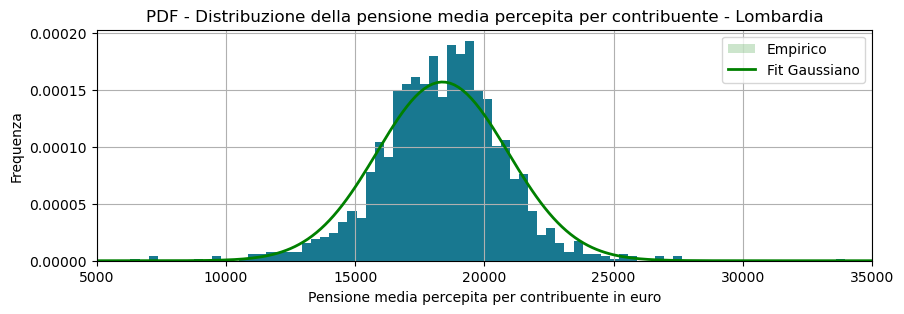

Test di Kolmogorov-Smirnov Lombardia:
Statistiche KS: 0.04220849129090015
P-value: 0.009073580642870638


SKEWNESS
	Lombdardia:  0.7821959333230779
KURTOSIS
	Lombardia:  11.578631542061403


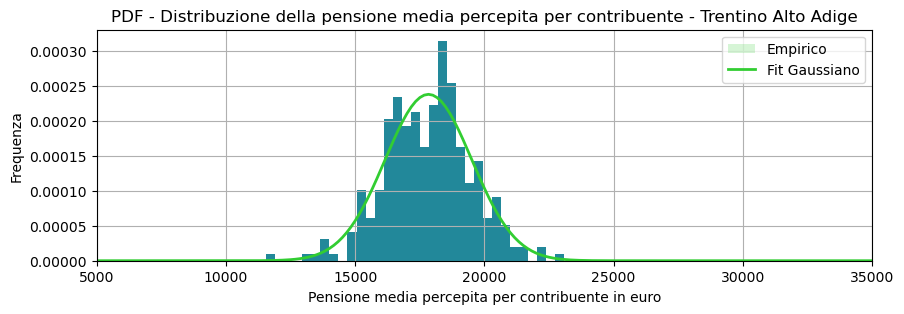

Test di Kolmogorov-Smirnov per Trentino:
Statistiche KS: 0.0401355858057334
P-value: 0.7383180484558295


SKEWNESS
	Trentino:  -0.08435287241739807
KURTOSIS
	Trentino:  0.45065784019998567


In [18]:
data_lom = dataframe[dataframe['Codice Istat Regione'] == 3]['Reddito da pensione - Ammontare in euro'].div(dataframe[dataframe['Codice Istat Regione'] == 3]['Reddito da pensione - Frequenza'].values)


# Plot
plt.figure(figsize=(10, 3))
data_lom.hist(bins=bins, density = True)

# Plot PDF
mean = np.mean(data_lom)
std2 = np.std(data_lom)

plt.hist(data_lom, bins=bins, color='green', alpha=0.2, density=True, label = "Empirico")
plt.xlabel('Pensione media percepita per contribuente in euro')
plt.ylabel('Frequenza')
plt.title('PDF - Distribuzione della pensione media percepita per contribuente - Lombardia')
plt.xlim(5000, 35000)

#Fit
mu, std = norm.fit(data_lom)
p = norm.pdf(x, mu, std)
plt.plot(x, p, color="green", linewidth=2, label= 'Fit Gaussiano')
plt.legend()
plt.show()



ks_statistic, p_value = kstest(data_lom, 'norm', args=(mean, std2))
print("Test di Kolmogorov-Smirnov Lombardia:")
print("Statistiche KS:", ks_statistic)
print("P-value:", p_value)
print('\n')
print("SKEWNESS")
lom_skew = skew(data_lom)
print('\tLombdardia: ', lom_skew)
lom_kur = kurtosis(data_lom)
print("KURTOSIS")
print('\tLombardia: ', lom_kur)



data_lom = dataframe[dataframe['Codice Istat Regione'] == 4]['Reddito da pensione - Ammontare in euro'].div(dataframe[dataframe['Codice Istat Regione'] == 4]['Reddito da pensione - Frequenza'].values)
# Plot
plt.figure(figsize=(10, 3))
data_lom.hist(bins=bins, density = True)

# Plot PDF
x = np.linspace(0, 1e6, 6000)

mean = np.mean(data_lom)
std = np.std(data_lom)

plt.hist(data_lom, bins=bins, color='limegreen', alpha=0.2, density=True, label="Empirico")
plt.xlabel('Pensione media percepita per contribuente in euro')
plt.ylabel('Frequenza')
plt.title('PDF - Distribuzione della pensione media percepita per contribuente - Trentino Alto Adige')
plt.xlim(5000, 35000)
mu, std = norm.fit(data_lom)


# Plot della PDF della distribuzione normale senza normalizzazione
p = norm.pdf(x, mu, std)
plt.plot(x, p, color="limegreen", linewidth=2, label= "Fit Gaussiano")
plt.legend()
plt.show()

ks_statistic, p_value = kstest(data_lom, 'norm', args=(mean, std))
print("Test di Kolmogorov-Smirnov per Trentino:")
print("Statistiche KS:", ks_statistic)
print("P-value:", p_value)
print('\n')
print("SKEWNESS")
lom_skew = skew(data_lom)
print('\tTrentino: ', lom_skew)
lom_kur = kurtosis(data_lom)
print("KURTOSIS")
print('\tTrentino: ', lom_kur)



Notiamo quindi che, per i valori di skewness e curtosi ottenuti, la regione Lombardia ha un andamento che si discosta molto da una distribuzione normale per la presenza di code molto allargate e per l'assenza di simmetria. Ne deduciamo dunque che il dover rigettare l'ipotesi di andamento gaussiano per il reddito da pensione per macro-aree sia dovuto al fatto che ci sono alcune regioni, come la Lombardia, nelle quali sono presenti alcuni contribuenti che si discostano ampiamente dall'andamento medio per regione e che possiedono un numero di province molto elevato; queste regioni quindi peseranno molto di più rispetto a regioni come il Trentino, per le quali l'ipotesi nulla non è da rigettare e che hanno un numero inferiore di province.


### 3. Matrice di correlazione e PCA
Analizziamo ora eventuali correlazioni tra le categorie di reddito attraverso l'utilizzo di una matrice di correlazione. 

In [19]:
media = media.reset_index()
media.columns = ['Codice Istat Regione', "Fabbricati", "Lavoro Dipendente", "Pensione", "Lavoro Autonomo", "Spettanza", "Spettanza Semplificata", "Partecipazione"]

In [20]:
redditi_columns = dataframe.columns[dataframe.columns.get_loc("Reddito da fabbricati - Frequenza"):dataframe.columns.get_loc("Reddito imponibile - Frequenza")]
redditi_per_regione = dataframe.groupby("Codice Istat Regione")[redditi_columns].sum()

colonne_reddito_cat = redditi_per_regione.columns[redditi_per_regione.columns.str.contains('Ammontare in euro')]
colonne_frequenza_cat = redditi_per_regione.columns[redditi_per_regione.columns.str.contains('Frequenza')]

perc = dataframe[colonne_reddito_cat].copy()
for colonna in dataframe[colonne_reddito_cat]:
    # Eseguire la divisione
    perc[colonna] /= dataframe['Numero contribuenti']

perc.columns =["Fabbricati", "Lavoro Dipendente", "Pensione", "Lavoro Autonomo", "Spettanza", "Spettanza Semplificata", "Partecipazione"]
perc["Codice Istat Regione"] = dataframe["Codice Istat Regione"]
perc.fillna(0, inplace=True)
perc

,Fabbricati,Lavoro Dipendente,Pensione,Lavoro Autonomo,Spettanza,Spettanza Semplificata,Partecipazione,Codice Istat Regione
0,637.410808,12324.045440,7704.101396,1115.574773,292.250347,755.884384,1382.750446,5
1,355.518519,9808.101852,6582.569444,0.000000,0.000000,0.000000,618.037037,3
2,738.442977,13822.711485,7270.738295,489.984394,0.000000,591.867947,942.831533,3
3,570.131595,9182.242293,6438.425822,415.590110,61.931926,417.807987,708.990275,9
4,415.740297,9129.256279,6804.961187,318.478311,0.000000,747.715183,588.710616,20
...,...,...,...,...,...,...,...,...
7899,352.150224,5621.869154,4764.076714,407.880846,71.750320,638.807655,333.607463,16
7900,616.526465,9707.809546,6329.579395,645.825614,1087.292060,801.696597,1249.005198,4
7901,432.249466,8436.470384,4912.942636,518.132604,325.098186,691.399413,598.356190,4
7902,496.522578,12152.804327,5889.461430,743.271402,315.661806,806.235183,2105.385701,4


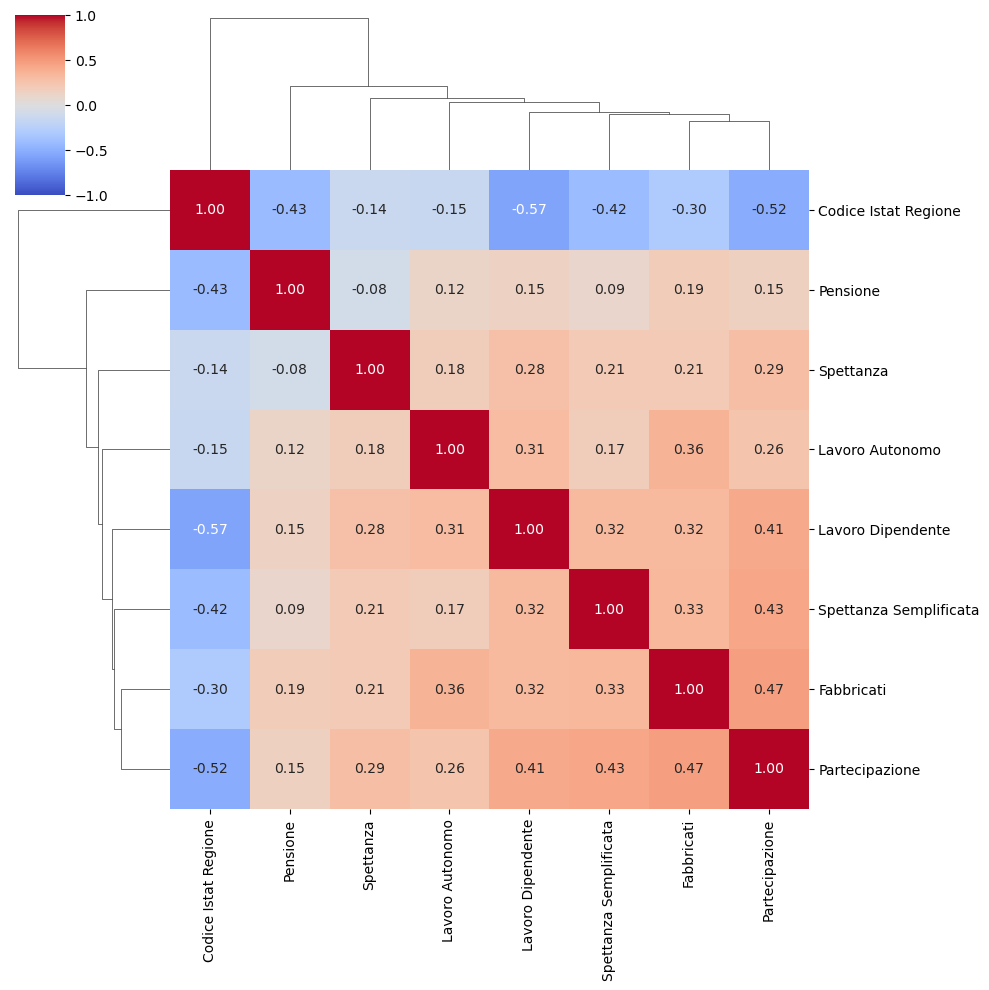

In [21]:
sns.clustermap(perc.corr(), vmin=-1, vmax=1, 
               cmap="coolwarm",
               annot=True,  # Visualizza i valori della matrice di correlazione
               fmt=".2f",   # Formato per i valori (2 cifre decimali)
               )

Dalla matrice di correlazione si può notare che le frequenze di contribuenti delle singole categorie di reddito, in percentuale rispetto ai contribuenti totali, siano scorrelate. In generale invece le frequenze anti-correlano con il codice Istat della Regione, ovvero spostandoci da Nord Italia verso il Sud Italia, il numero di contribuenti diminuisce in ognuna delle categorie, come già analizzato nella Sezione 2.


Andiamo quindi a fare una *Principal Component Analysis* e stabilire se e in che modo sia possibile identificare una certa regione a partire dal minor numero possibile di parametri.

In [22]:
correlation_matrix = perc.corr()
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()

X = perc.drop('Codice Istat Regione',axis=1)
y = perc['Codice Istat Regione']
X = scaler.fit_transform(X)

dfx = pd.DataFrame(X)
pca = PCA(n_components=None)
dfx_pca = pca.fit(dfx)

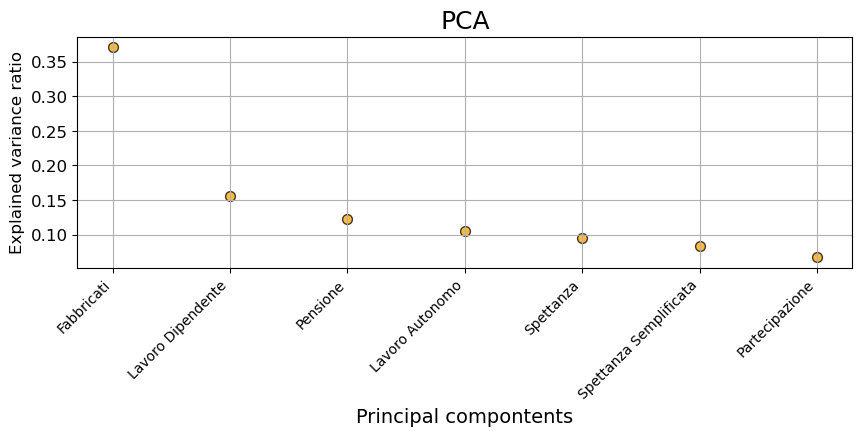

In [23]:
plt.figure(figsize=(10,3))
plt.scatter(x=[i+1 for i in range(len(dfx_pca.explained_variance_ratio_))],
            y=dfx_pca.explained_variance_ratio_,
            s=50, alpha=0.75, c='orange', edgecolor='k')

plt.grid(True)
plt.title("PCA", fontsize=18)
plt.xlabel("Principal compontents", fontsize=14)

# Ottieni i nomi delle categorie dal DataFrame originale df
nomi_categorie = perc.columns[:-1]

# Aggiungi i nomi delle categorie come etichette sull'asse x
plt.xticks([i+1 for i in range(len(dfx_pca.explained_variance_ratio_))], nomi_categorie, fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.ylabel("Explained variance ratio", fontsize=12)
plt.show()


Dall'analisi del grafico emerge che la prima componente principale è responsabile di circa il $37\%$ della varianza complessiva dei dati, mentre la seconda componente ne spiega circa il $16\%$. Pertanto, considerando esclusivamente le prime due componenti, è possibile spiegare approssimativamente il $53\%$ della varianza totale.

### 4. Conclusioni

In conclusione, abbiamo analizzato l'andamento del reddito medio per regione e osservato che questo si distribuisce in maniera differente nelle macro-aree dell'Italia. 

Abbiamo poi evidenziato quali siano i contributi maggiori al reddito per le singole regioni italiane e osservato che questi sono gli stessi per tutte. Ci siamo soffermati su uno di questi parametri per cercare di analizzare l'andamento di tale categoria di reddito all'interno delle macro-aree. Abbiamo dovuto escludere che tale andamento fosse normale, verificando poi che questo sia dovuto a regioni specifiche che presentano code non gaussiane nella propria distribuzione. 

Infine abbiamo studiato se le categorie di reddito fossero in qualche modo correlate tra di loro, non essendo infatti noto se il singolo contribuente abbia un unico valore di reddito. Abbiamo quindi verificato che tra di loro tali categorie sono scorrelate, ma che tutte anti-correlano con il codice di regione. 